<a href="https://colab.research.google.com/github/Coyote-Schmoyote/portrait-generation-dcgan/blob/main/GAN_portriat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image generation with GAN
This notebook looks into the process of generating art portraits using GAN. The project is inspired by the AI-generated portrait of Edmond de Belamy (2018) that was sold at Christie's for $432,000. 
## 1. Problem Definition
Generate new images based on the input images from the art portraits.
## 2. Data
The data used in this project is the combination of  Portrait Paintings dataset (https://www.kaggle.com/datasets/deewakarchakraborty/portrait-paintings) and Art Portraits dataset (https://www.kaggle.com/datasets/karnikakapoor/art-portraits), both available on Kaggle. The Portrait Painting dataset consists of 5734 images, and Art Portraits dataset consists of 4117 images.
## 3. Approach
For this project, we will take the following approach:
1. Import the tools
2. Clean the dataset
3. Explore and process the images
4. Build Discriminator and Generator, and combine them into a GAN model
5. Describe the training steps
6. Train the model
7. Display the result (generated portraits)

##4. Evaluation
There is no function to evaluate the performance of a GAN model, which means that the performance of the model will be evaluated based on the quality of the generated images.

# Import the tools
First, we will import all the necessary tools. We will use the same ones we used for the MNIST digit generation: `os`, `numpy`, `random`, `matplotlib`, `open cv`, and `tensorflow`.

In [1]:
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import numpy as np
import random 
from matplotlib import pyplot as plt
import cv2
from google.colab.patches import cv2_imshow 
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import preprocessing

In [3]:
cv2.__version__

'4.6.0'

In [4]:
tf.__version__

'2.8.2'

# Clean and prepare dataset
The goal of this project is to generate portraits based on the input images. The original combined dataset consisted of 9851 art portraits. However, not all images were suitable for the task, because some of them featured more than one person in the painting, depicted the whole body, or were too abstract.


To recevie the desirable result, we have to follow the  rule "garbage in, garbage out," and clean our dataset properly. FOr this project, I removed images that depict full-body portraits, have more than one person in the image, side portaits, too abstract portraits (where it is impossible to tell wether an image depicts a face), portraits of children, black and white portraits, pencil drawings and prints. GAN will learn the features of the input images, and try to generate something similar, so we will receive the result based on the style of images in our dataset. This is a space for some creativity and experimentation, for example, you can choose images depicting only one gender, one face, only particular color scheme, etc. Depending on this, the output will also differ.

The process of cleaning the dataset might take several hours. 

In [62]:
project_folder = "/content/drive/MyDrive/ml-projects/GAN/Images/"

In [63]:
image_list = os.listdir(project_folder)
print(f"Number of images after data cleaning: {len(image_list)}")

Number of images after data cleaning: 5606


## How many images is enough for a GAN model?
GAN models typically require a lot of input data to generate high-quality images. It typically takes tens or even hundreds of thousands of images to train GAN. In our MNIST hand-writeen digit generation project, for example, we used a dataset of 60,000 images. In keras face generation example (https://keras.io/examples/generative/dcgan_overriding_train_step/), a dataset of 200,000 images is used. However, often we don't have access to that many examples. In this case, several thousands can be enough. Image generation based on CIFAR10 dataset that features 10 different classes of object, for example, uses approximately 6,000 images per class. 

In our case, we have 5,606 images after cleaning the data. This should be enough to train our GAN model. It is also worth noting, that the more images we input, the faster we can get plausible result, and the less images we have, the more epochs we might have to go through to receive similar output. 

# Explore and process the images
Exploratory Data Analysis (EDA) is important in any machine learning project, including GAN image generation. We need to familiarize ourselves with our dataset, check the data types of the files, and pre-process it for deep learning.


## Display images
First, let's select a random image from our `project_folder` and display it.

In [7]:
def select_random_image(folder):
  img_list = os.listdir(folder)
  image = os.path.join(folder, random.choice(img_list))
  image = plt.imread(image)
  image_array = np.array(image)
  return image_array

In [8]:
select_random_image(project_folder)

array([[[17, 15, 26],
        [19, 19, 29],
        [16, 19, 34],
        ...,
        [20, 20, 22],
        [20, 19, 24],
        [19, 19, 19]],

       [[17, 21, 24],
        [15, 24, 29],
        [12, 20, 33],
        ...,
        [19, 17, 28],
        [22, 23, 27],
        [20, 22, 21]],

       [[14, 18, 17],
        [15, 20, 24],
        [13, 17, 26],
        ...,
        [22, 15, 31],
        [20, 20, 30],
        [19, 20, 25]],

       ...,

       [[ 4, 14,  3],
        [ 6, 11,  7],
        [ 5, 10, 14],
        ...,
        [10,  7, 24],
        [12, 10, 24],
        [13,  9, 26]],

       [[ 0,  9,  8],
        [ 0,  8, 11],
        [ 2, 11, 18],
        ...,
        [15, 14, 20],
        [17, 12, 19],
        [18, 10, 25]],

       [[ 2,  6, 15],
        [ 3,  7, 16],
        [10, 10, 22],
        ...,
        [26, 23, 18],
        [25, 16, 19],
        [25, 11, 28]]], dtype=uint8)

As we remember from our previous projects with images, computers keep images as arrays of integers. In order to display the images, we typically need to use help tools. There are 3 libraries that can do this job: `matplotlib` and `cv2` (we already have experience working with them), and another library is `Pillow`, or `PIL`.
For now, let's use `plt.imshow()` to display the random image.

Each time that we run the cell, we will get a new random image from our 5,606 images.

In [9]:
def display_random_image(folder):
  image = select_random_image(folder)
  plt.imshow(image)
  plt.axis("off")
  plt.title("Sample Portrait")

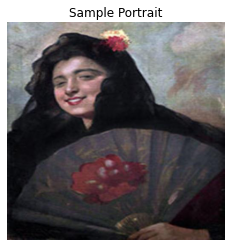

In [10]:
display_random_image(project_folder)

Great! A lovely portrait. Now, let's display several images, so we can understand better the general context of our dataset, and see how the images relate to each other. To do this, we will create an empty array `images`, and append the images to the array by looping through our `select_random_image()` function that we wrote earlier. Here, we loop through the function 4 times to display 4 random images. Similar to the previous `display_random_image()` function, each time we refresh the cell, we will get a different combination of images.

In [11]:
def display_random_images(folder):
  images = []
  for _ in range(4):
    images.append(select_random_image(folder))
  
  fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=len(images), sharey=True, figsize = (14, 7))
  fig.tight_layout()
  ax1.imshow(images[0])
  ax1.axis("off")
  ax2.imshow(images[1])
  ax2.axis("off")
  ax3.imshow(images[2])
  ax3.axis("off")
  ax4.imshow(images[3])
  ax4.axis("off");

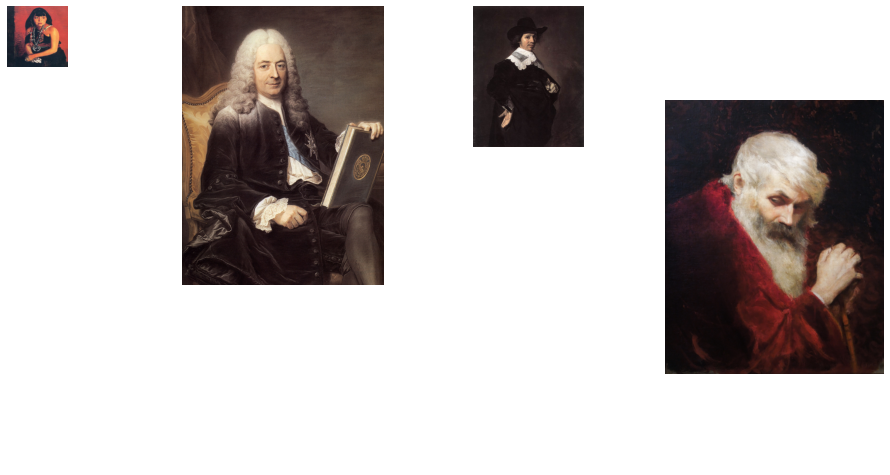

In [12]:
display_random_images(project_folder)

## Process images
As we can see, all the images are of different sizes. One step of the image pre-processing will be resizing the images to the same size. 
Generally, image preparation follows the following steps:
1. Resize the images
2. Change the shape of the array
3. Normalize pixel values from 0 to 1
4. Save the images as a dataset


In [13]:
def create_image_array(path):
  for image in os.listdir(project_folder):
    image_array = cv2.imread(os.path.join(project_folder, image))
  return image_array

In [15]:
image_array = create_image_array(project_folder)
print(f"Original image shape: {image_array.shape}")

Original image shape: (944, 786, 3)


## How to choose an image size for GAN?
There are no specific guidelines for chooseing the size of the input images, however, there are several things to keep in mind. For example, the sizes are often chosen as the power of two, for example, 32x32px, 64x64px, 96x96px, etc. However, technically, any image size should work fine. The smaller the input image, the less features it has, and the faster it will train. At the same time, the smaller the image, the poorer the quality. But, if we choose an image that is too big, we might not have enough memory or computing power, particularly if working on local server or free services such as Google Colab.

For our MNIST handwritten digit generation, we used 23x23px size. Let's see the differences in sizes on an example from our dataset.

In [16]:
def display_resized_image(image, size):
  image = cv2.resize(image, (size, size))
  image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
  print(f"Resized {size}x{size}px image shape: {image.shape}")
  plt.imshow(image);

Resized 112x112px image shape: (112, 112, 3)


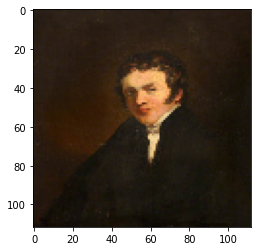

In [17]:
display_resized_image(image_array, 112)

Resized 64x64px image shape: (64, 64, 3)


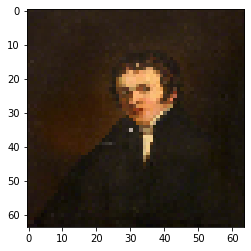

In [18]:
display_resized_image(image_array, 64)

Resized 23x23px image shape: (23, 23, 3)


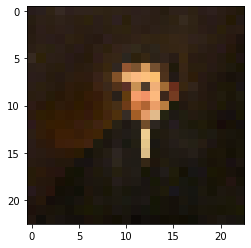

In [19]:
display_resized_image(image_array, 23)

We can see that the quality differs quite a bit. 23x23 px size that we used for MNIST project would be too small for portrait generation, because we cannot see any distinct features. 112x112 has a good quality, however, it might be too complicated for our network to grasp all the features. So for this example, we will stick with 64x64 size.

In [20]:
size = 64
path = project_folder
color_channels = 3

In [21]:
def load_real_samples(path, size):
  real_samples = []
  for image in os.listdir(path):
    try:
      images = cv2.imread(os.path.join(path, image))
      images = cv2.resize(images, (size, size))
      images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB)
      real_samples.append(images)
    except Exception as e:
      pass
  return real_samples

In [22]:
real_samples = load_real_samples(path, size)
print(f"Images in project folder: {len(os.listdir(project_folder))}, Images in dataset: {len(real_samples)}")

Images in project folder: 5606, Images in dataset: 5604


In [23]:
def create_dataset(path, size, color_channels):
  real_samples = load_real_samples(path, size)
  dataset = np.array(real_samples).reshape(-1, size, size, color_channels) #-1 means any number
  dataset = dataset / 255.0
  return dataset

In [24]:
dataset = create_dataset(path, size, color_channels)
dataset.shape

(5604, 64, 64, 3)

## Keras API
In this project, we will use the Keras Sequential API to build our DCGAN network.
Keras is an API developed by Google that simplifies the process of building deep neural networks. Keras is built on top of TensorFlow 2, and provides inbuild modules for the majority of neural network computations, runs smoothly on CPU and GPU, supports almost all neural network models, and gained popularity for being flexible and fast.

Keras provides two ways of building deep neural network models: Sequential and functional. The sequential API allows us to create models layer-by-layer for most deep learning tasks. In this project, we will build a Sequential model. Functional models, on the other hand, are more complex, but allows more control over the resulting model architecture.


### DCGAN
For this project, we will implement the Deep Convolutional GAN (DCGAN) architecture.The goal of our project is to generate art portraits, based on the examples from the training dataset. This can be performed with both simple GAN and DCGAN, and  the initial process is essentially the same. 

The generator takes inpiut images to create new synthetic images that it can then pass to the discriminator. The discriminator has to recognize the authentic images from the ones created by the generator. It takes both real and fake images and returns probabilities between 0 and 1 of whether an image is real or fake. 
For DCGAN, the discriminator network is a typical convolutional network that categorizes images, and the generator is an inverse convolutional network, which takes a vector of random noise and upsamples it to an image. Because of this feature, it can produce more accurate images with less noise, compared to a simple GAN. 



In [25]:
def make_discriminator(in_shape=(64,64,3)):
  #instantiate the model
  model = keras.Sequential(name="Discriminator")

  #add 1st set of convolutional + normalization layers
  model.add(layers.Conv2D(64, kernel_size= 4, strides=2, padding="same", input_shape=in_shape))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Dropout(0.3))

  #add 2nd set of convolutional + normalization layers
  model.add(layers.Conv2D(128, kernel_size = 4, strides=2, padding="same"))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Dropout(0.3))

  #add 2nd set of convolutional + normalization layers
  model.add(layers.Conv2D(128, kernel_size = 4, strides=2, padding="same"))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Dropout(0.3))

  #Add final flatten and output layers
  model.add(layers.Flatten())
  model.add(layers.Dense(1, activation="sigmoid"))

  #compile the model
  model.compile(loss = "binary_crossentropy", 
                optimizer = keras.optimizers.Adam(lr=0.0002, beta_1=0.5),
                metrics = ["accuracy"])
  return model

In [26]:
discriminator = make_discriminator()

discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)       

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


* Input shape of generator must match the last conv layer of discriminator
* Latent_dim must match the number of filters in the input shape of generator

In [27]:
# make the generator
def make_generator(latent_dim):
	model = keras.Sequential(name="Generator")
 
	# foundation for 14x14 image
	n_nodes = 8 * 8 * 128
	model.add(layers.Dense(n_nodes, input_dim=latent_dim))
	model.add(layers.LeakyReLU(alpha=0.2))
	model.add(layers.Reshape((8, 8, 128)))
 
	# upsample to 28x28
	model.add(layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
	model.add(layers.LeakyReLU(alpha=0.2))
 
	# upsample to 56x56
	model.add(layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding='same'))
	model.add(layers.LeakyReLU(alpha=0.2))
 
 	# upsample to 112x
	model.add(layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding='same'))
	model.add(layers.LeakyReLU(alpha=0.2))
 
 
	model.add(layers.Conv2D(3, (5,5), activation='sigmoid', padding='same'))
	return model


In [28]:
latent_dim = 128
generator = make_generator(latent_dim)
generator.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              1056768   
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 8192)              0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                               

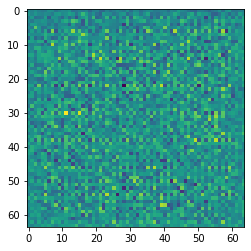

In [29]:
random_noise = tf.random.normal([1, 128])
generated_noise = generator(random_noise, training=False)

plt.imshow(generated_noise[0, :, :, 0]);

In [30]:
def make_gan(generator, discriminator):
  discriminator.trainable = False
  model = keras.Sequential(name="GAN")

  #add generator
  model.add(generator)

  # add discriminator
  model.add(discriminator)

  #compile model
  optimizer = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss="binary_crossentropy",
                optimizer=optimizer)
  return model

In [31]:
gan = make_gan(generator, discriminator)

gan.summary()

Model: "GAN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Generator (Sequential)      (None, 64, 64, 3)         3979651   
                                                                 
 Discriminator (Sequential)  (None, 1)                 404801    
                                                                 
Total params: 4,384,452
Trainable params: 3,979,651
Non-trainable params: 404,801
_________________________________________________________________


In [32]:
def select_real_samples(dataset, n_samples):
  random_samples = np.random.randint(0, dataset.shape[0], n_samples)
  real_images = dataset[random_samples]
  real_labels = np.ones((n_samples, 1))
  return real_images, real_labels

In [33]:
def generate_latent_points(latent_dim, n_samples):
  generator_input = np.random.randn(latent_dim * n_samples)
  generator_input = generator_input.reshape(n_samples, latent_dim)
  return generator_input

In [34]:
def generate_fake_samples(generator, latent_dim, n_samples):
  generator_input = generate_latent_points(latent_dim, n_samples)
  fake_images = generator.predict(generator_input)
  fake_labels = np.zeros((n_samples, 1))
  return fake_images, fake_labels

In [4]:
output_folder = "/content/drive/MyDrive/ml-projects/GAN/output/"
output_images = os.path.join(output_folder, "images/")
output_models = os.path.join(output_folder, "models/")

In [36]:
def save_plot(examples, epoch, n=3):

  fig = plt.figure(figsize=(12, 12))
  for i in range(n * n):
    plt.subplot(n, n, 1 + i)
    plt.axis("off")
    plt.imshow(examples[i, :, :, :])
  filename = "generated_portrait_e%03d.png" % (epoch+1)
  plt.savefig(os.path.join(output_images, filename))
  plt.close()

In [37]:
def summarize_performance(epoch, generator, discriminator, dataset, latent_dim, n_samples=100):
  real_images, real_labels = select_real_samples(dataset, n_samples)
  _, accuracy_real = discriminator.evaluate(real_images, real_labels, verbose=0)
  fake_images, fake_labels = generate_fake_samples(generator, latent_dim, n_samples)
  _, accuracy_fake = discriminator.evaluate(fake_images, fake_labels, verbose=0)
  print(">Accuracy detecting real: %.0f%%, detecting fake: %.0f%%" % (accuracy_real*100, accuracy_fake*100))
  save_plot(fake_images, epoch)
  model_folder = "models/"
  filename = "generator_model_%03d.h5" % (epoch + 1)
  generator.save(os.path.join(output_models, filename))

In [38]:
def train(generator, discriminator, gan, dataset, latent_dim, n_epochs=300, n_batch=32):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)

  for epoch in range(n_epochs):
    for batch in range(bat_per_epo):
      real_images, real_labels = select_real_samples(dataset, half_batch)
      fake_images, fake_labels = generate_fake_samples(generator, latent_dim, half_batch)
      images, labels = np.vstack((real_images, fake_images)), np.vstack((real_labels, fake_labels))
      
      #train the discriminator
      d_loss, _ = discriminator.train_on_batch(images, labels)
      images_gan = generate_latent_points(latent_dim, n_batch)
      labels_gan = np.ones((n_batch, 1))
      g_loss = gan.train_on_batch(images_gan, labels_gan)
    if (epoch+1) % 10 == 0:
      print(">%d, %d/%d, d=%.3f, g=%.3f" % (epoch+1, batch+1, bat_per_epo, d_loss, g_loss))
      summarize_performance(epoch, generator, discriminator, dataset, latent_dim)

In [39]:
discriminator = make_discriminator()
generator = make_generator(latent_dim)
gan = make_gan(generator, discriminator)
latent_dim = 128

In [ ]:
%%time
train(generator, discriminator, gan, dataset, latent_dim)

>10, 175/175, d=0.765, g=0.784
>Accuracy detecting real: 36%, detecting fake: 49%


>20, 175/175, d=0.708, g=0.696
>Accuracy detecting real: 60%, detecting fake: 52%


>30, 175/175, d=0.698, g=0.722
>Accuracy detecting real: 24%, detecting fake: 81%


>40, 175/175, d=0.690, g=0.742
>Accuracy detecting real: 19%, detecting fake: 90%


>50, 175/175, d=0.676, g=0.647
>Accuracy detecting real: 91%, detecting fake: 12%


>60, 175/175, d=0.704, g=0.680
>Accuracy detecting real: 80%, detecting fake: 19%


>70, 175/175, d=0.682, g=0.713
>Accuracy detecting real: 38%, detecting fake: 72%


>80, 175/175, d=0.687, g=0.784
>Accuracy detecting real: 10%, detecting fake: 93%


>90, 175/175, d=0.712, g=0.746
>Accuracy detecting real: 4%, detecting fake: 97%


>100, 175/175, d=0.699, g=0.703
>Accuracy detecting real: 56%, detecting fake: 43%


>110, 175/175, d=0.712, g=0.680
>Accuracy detecting real: 58%, detecting fake: 37%


>120, 175/175, d=0.688, g=0.713
>Accuracy detecting real: 22%, detecting fake: 68%


>130, 175/175, d=0.714, g=0.675
>Accuracy detecting real: 68%, detecting fake: 30%


>140, 175/175, d=0.699, g=0.622
>Accuracy detecting real: 86%, detecting fake: 4%


>150, 175/175, d=0.692, g=0.769
>Accuracy detecting real: 9%, detecting fake: 99%


>160, 175/175, d=0.686, g=0.630
>Accuracy detecting real: 98%, detecting fake: 0%


>170, 175/175, d=0.729, g=0.733
>Accuracy detecting real: 21%, detecting fake: 79%


>180, 175/175, d=0.745, g=0.735
>Accuracy detecting real: 38%, detecting fake: 80%


>190, 175/175, d=0.673, g=0.712
>Accuracy detecting real: 54%, detecting fake: 78%


>200, 175/175, d=0.690, g=0.659
>Accuracy detecting real: 99%, detecting fake: 5%


In [5]:
len(os.listdir(output_images))

20

In [48]:
def display_image(folder, epoch_no):
  path = os.path.join(folder, "generated_portrait_e{:03d}.png".format(epoch_no))
  image = cv2.imread(path)
  print(f"Epoch Nr. {epoch_no}")
  cv2_imshow(image)

Epoch Nr. 10


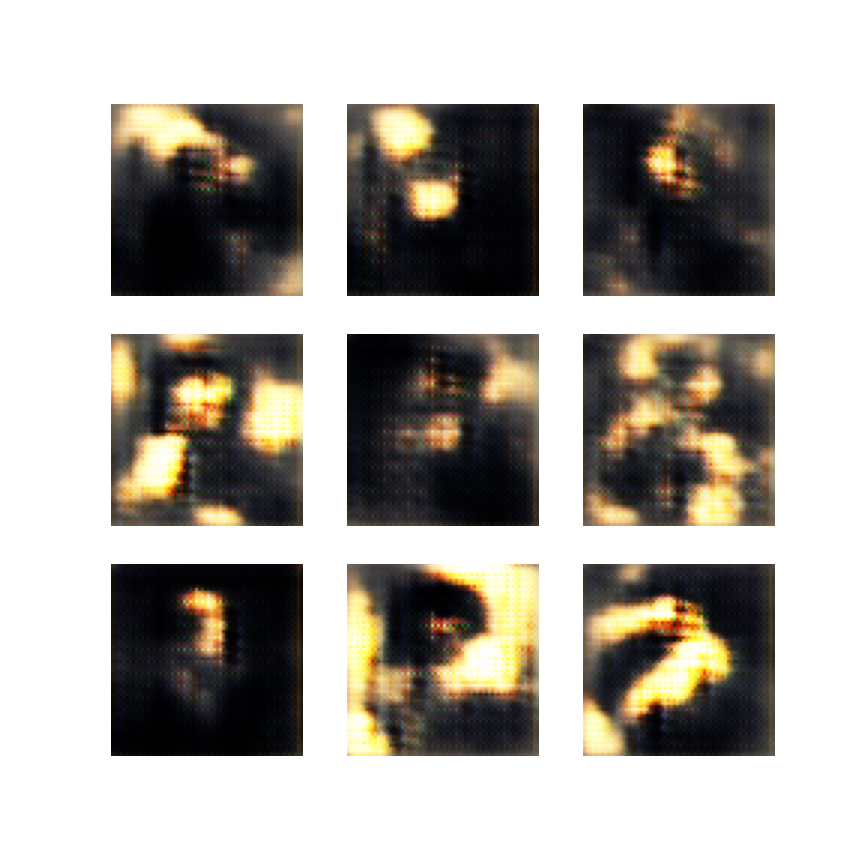

In [52]:
display_image(output_images, 10)

Epoch Nr. 40


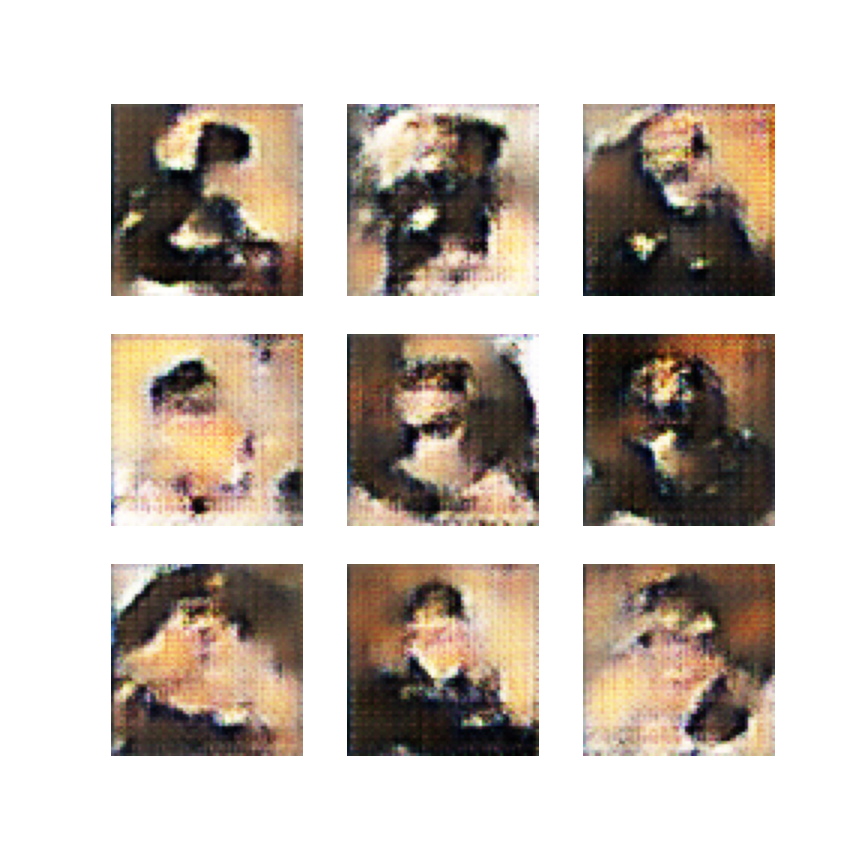

In [57]:
display_image(output_images, 40)

Epoch Nr. 80


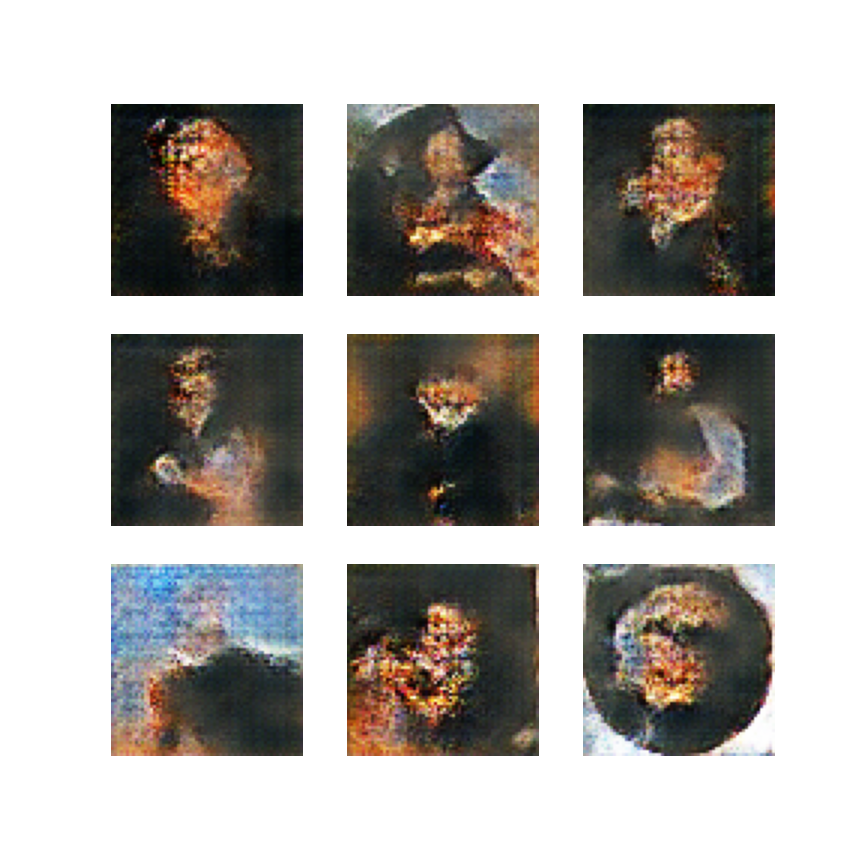

In [58]:
display_image(output_images, 80)

Epoch Nr. 140


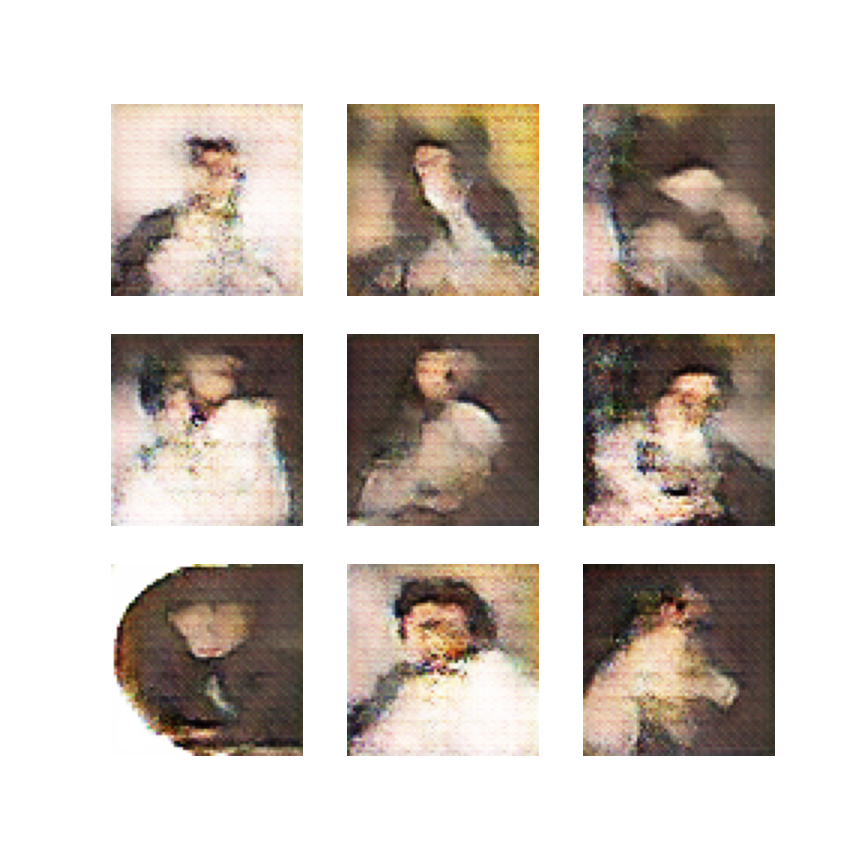

In [59]:
display_image(output_images, 140)

Epoch Nr. 190


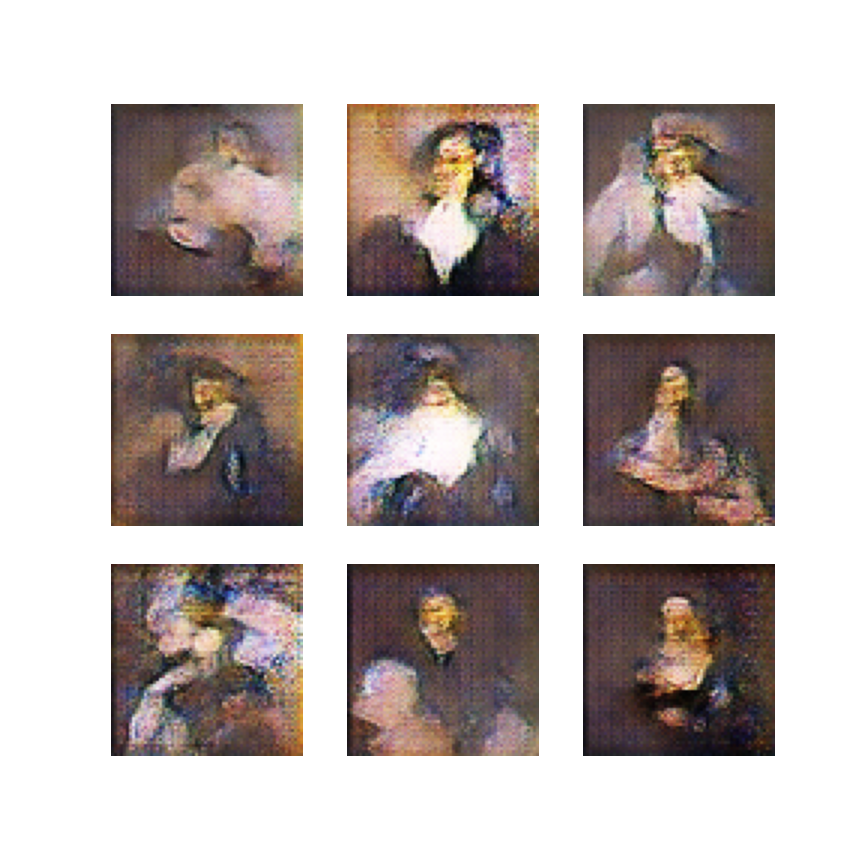

In [61]:
display_image(output_images, 190)